In [1]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from tqdm import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

import mNDWS_models as mndws_models
mndws_models.set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)

Loading shared models module from: /sfs/weka/scratch/jbm2rt/DS6050/wildfire-spread-prediction/mNDWS_models.py
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Device: cuda
Reusing NPZ tiles from pipeline at: /scratch/jbm2rt/wildfire_npz_tiles_mndws_v1
Device: cuda


In [2]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")

Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channel stats computed -> torch.Size([21]) torch.Size([21])
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [3]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
pos_weight = models.pos_weight_from_loader(train_loader)

bundle = models.build_physics_unet_bundle(
    CHANNELS_FOR_MODEL,
    meanC,
    stdC,
    base_width=80,
    ema_decay=0.999,
    loss_type="hybrid",  # combines focal + Tversky
    loss_kwargs={
        "pos_weight": pos_weight,
        "focal_alpha": 0.25,
        "focal_gamma": 2.0,
        "focal_weight": 0.5,  # 0→pure Tversky, 1→pure focal
        "tversky_alpha": 0.7,
        "tversky_beta": 0.3,
    },
)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]
criterion = bundle["criterion"]

optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.amp.GradScaler(device="cuda", enabled=amp_enabled)
if amp_enabled:
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda")
else:
    autocast_ctx = nullcontext
amp_stream = autocast_ctx

print(f"pos_weight = {float(pos_weight):.3f}")
print(
    f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M"
)
print(f"Loss config: {bundle['loss_config']}")

PhysicsPrior UNet init -> in:16 base:80 | parameters: 12.04 M
pos_weight = 32.897
Model parameters: 12.04 M
Loss config: {'type': 'hybrid', 'kwargs': {'pos_weight': tensor(32.8968, device='cuda:0'), 'focal_alpha': 0.25, 'focal_gamma': 2.0, 'focal_weight': 0.5, 'tversky_alpha': 0.7, 'tversky_beta': 0.3}}


In [4]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 100
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist, val_iou_hist = [], [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5, 0.0
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    yhat = (p >= best_thr).astype(np.float32)
    intersection = float((yhat * t).sum())
    union = float(yhat.sum() + t.sum() - intersection)
    iou = intersection / (union + 1e-8)
    return float(ap), float(f1.max()), float(best_thr), float(iou)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr, iou = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    val_iou_hist.append(iou)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | VAL IoU {iou:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

[Physics] Epoch 00 | loss 0.5304 | VAL AP 0.3242 | VAL F1* 0.4412 | VAL IoU 0.2830 | thr≈0.677


[Physics] Epoch 01 | loss 0.5089 | VAL AP 0.3704 | VAL F1* 0.4578 | VAL IoU 0.2969 | thr≈0.662


[Physics] Epoch 02 | loss 0.5020 | VAL AP 0.3818 | VAL F1* 0.4669 | VAL IoU 0.3046 | thr≈0.698


[Physics] Epoch 03 | loss 0.4982 | VAL AP 0.4231 | VAL F1* 0.4817 | VAL IoU 0.3173 | thr≈0.700


[Physics] Epoch 04 | loss 0.4913 | VAL AP 0.4137 | VAL F1* 0.4781 | VAL IoU 0.3141 | thr≈0.663


[Physics] Epoch 05 | loss 0.4888 | VAL AP 0.4265 | VAL F1* 0.4811 | VAL IoU 0.3168 | thr≈0.695


[Physics] Epoch 06 | loss 0.4855 | VAL AP 0.4298 | VAL F1* 0.4842 | VAL IoU 0.3194 | thr≈0.700


[Physics] Epoch 07 | loss 0.4791 | VAL AP 0.4211 | VAL F1* 0.4764 | VAL IoU 0.3127 | thr≈0.709


[Physics] Epoch 08 | loss 0.4769 | VAL AP 0.4041 | VAL F1* 0.4699 | VAL IoU 0.3071 | thr≈0.723


[Physics] Epoch 09 | loss 0.4708 | VAL AP 0.4260 | VAL F1* 0.4824 | VAL IoU 0.3178 | thr≈0.690


[Physics] Epoch 10 | loss 0.4690 | VAL AP 0.4032 | VAL F1* 0.4652 | VAL IoU 0.3031 | thr≈0.682


[Physics] Epoch 11 | loss 0.4600 | VAL AP 0.4261 | VAL F1* 0.4887 | VAL IoU 0.3234 | thr≈0.671


[Physics] Epoch 12 | loss 0.4473 | VAL AP 0.4091 | VAL F1* 0.4760 | VAL IoU 0.3123 | thr≈0.638


[Physics] Epoch 13 | loss 0.4435 | VAL AP 0.4131 | VAL F1* 0.4802 | VAL IoU 0.3159 | thr≈0.641


[Physics] Epoch 14 | loss 0.4311 | VAL AP 0.3939 | VAL F1* 0.4457 | VAL IoU 0.2867 | thr≈0.711


[Physics] Epoch 15 | loss 0.4263 | VAL AP 0.4201 | VAL F1* 0.4850 | VAL IoU 0.3201 | thr≈0.660


[Physics] Epoch 16 | loss 0.4196 | VAL AP 0.4107 | VAL F1* 0.4739 | VAL IoU 0.3105 | thr≈0.662


[Physics] Epoch 17 | loss 0.4143 | VAL AP 0.4026 | VAL F1* 0.4565 | VAL IoU 0.2958 | thr≈0.652


[Physics] Epoch 18 | loss 0.4062 | VAL AP 0.4291 | VAL F1* 0.4920 | VAL IoU 0.3263 | thr≈0.641


[Physics] Epoch 19 | loss 0.3993 | VAL AP 0.4122 | VAL F1* 0.4671 | VAL IoU 0.3047 | thr≈0.722


[Physics] Epoch 20 | loss 0.4014 | VAL AP 0.4270 | VAL F1* 0.4822 | VAL IoU 0.3177 | thr≈0.764


[Physics] Epoch 21 | loss 0.4020 | VAL AP 0.4183 | VAL F1* 0.4897 | VAL IoU 0.3243 | thr≈0.707


[Physics] Epoch 22 | loss 0.3974 | VAL AP 0.4387 | VAL F1* 0.4964 | VAL IoU 0.3301 | thr≈0.670


[Physics] Epoch 23 | loss 0.3907 | VAL AP 0.4345 | VAL F1* 0.5001 | VAL IoU 0.3334 | thr≈0.664


[Physics] Epoch 24 | loss 0.3824 | VAL AP 0.4180 | VAL F1* 0.4934 | VAL IoU 0.3275 | thr≈0.632


[Physics] Epoch 25 | loss 0.3901 | VAL AP 0.4196 | VAL F1* 0.4814 | VAL IoU 0.3170 | thr≈0.629


[Physics] Epoch 26 | loss 0.3808 | VAL AP 0.4378 | VAL F1* 0.5048 | VAL IoU 0.3376 | thr≈0.668


[Physics] Epoch 27 | loss 0.3739 | VAL AP 0.4242 | VAL F1* 0.4872 | VAL IoU 0.3220 | thr≈0.660


[Physics] Epoch 28 | loss 0.3722 | VAL AP 0.4284 | VAL F1* 0.4893 | VAL IoU 0.3239 | thr≈0.677


[Physics] Epoch 29 | loss 0.3641 | VAL AP 0.4240 | VAL F1* 0.4945 | VAL IoU 0.3285 | thr≈0.666


[Physics] Epoch 30 | loss 0.3658 | VAL AP 0.4315 | VAL F1* 0.4952 | VAL IoU 0.3291 | thr≈0.690


[Physics] Epoch 31 | loss 0.3562 | VAL AP 0.4327 | VAL F1* 0.5053 | VAL IoU 0.3381 | thr≈0.665


[Physics] Epoch 32 | loss 0.3517 | VAL AP 0.4403 | VAL F1* 0.5066 | VAL IoU 0.3393 | thr≈0.664


[Physics] Epoch 33 | loss 0.3500 | VAL AP 0.4518 | VAL F1* 0.5142 | VAL IoU 0.3460 | thr≈0.708


[Physics] Epoch 34 | loss 0.3464 | VAL AP 0.4164 | VAL F1* 0.4859 | VAL IoU 0.3209 | thr≈0.599


[Physics] Epoch 35 | loss 0.3432 | VAL AP 0.4407 | VAL F1* 0.5107 | VAL IoU 0.3429 | thr≈0.587


[Physics] Epoch 36 | loss 0.3596 | VAL AP 0.4520 | VAL F1* 0.5180 | VAL IoU 0.3496 | thr≈0.527


[Physics] Epoch 37 | loss 0.3317 | VAL AP 0.4489 | VAL F1* 0.5135 | VAL IoU 0.3454 | thr≈0.671


[Physics] Epoch 38 | loss 0.3316 | VAL AP 0.4547 | VAL F1* 0.5139 | VAL IoU 0.3458 | thr≈0.517


[Physics] Epoch 39 | loss 0.3240 | VAL AP 0.4331 | VAL F1* 0.4992 | VAL IoU 0.3326 | thr≈0.657


[Physics] Epoch 40 | loss 0.3253 | VAL AP 0.4369 | VAL F1* 0.5011 | VAL IoU 0.3343 | thr≈0.709


[Physics] Epoch 41 | loss 0.3204 | VAL AP 0.4488 | VAL F1* 0.5197 | VAL IoU 0.3511 | thr≈0.677


[Physics] Epoch 42 | loss 0.3101 | VAL AP 0.4452 | VAL F1* 0.5024 | VAL IoU 0.3355 | thr≈0.559


[Physics] Epoch 43 | loss 0.3106 | VAL AP 0.4565 | VAL F1* 0.5198 | VAL IoU 0.3512 | thr≈0.652


[Physics] Epoch 44 | loss 0.3016 | VAL AP 0.4732 | VAL F1* 0.5269 | VAL IoU 0.3576 | thr≈0.618


[Physics] Epoch 45 | loss 0.2935 | VAL AP 0.4647 | VAL F1* 0.5184 | VAL IoU 0.3499 | thr≈0.561


[Physics] Epoch 46 | loss 0.2884 | VAL AP 0.4676 | VAL F1* 0.5261 | VAL IoU 0.3569 | thr≈0.650


[Physics] Epoch 47 | loss 0.2810 | VAL AP 0.4572 | VAL F1* 0.5148 | VAL IoU 0.3466 | thr≈0.659


[Physics] Epoch 48 | loss 0.2821 | VAL AP 0.4525 | VAL F1* 0.5137 | VAL IoU 0.3457 | thr≈0.658


[Physics] Epoch 49 | loss 0.2741 | VAL AP 0.4585 | VAL F1* 0.5119 | VAL IoU 0.3440 | thr≈0.577


[Physics] Epoch 50 | loss 0.2710 | VAL AP 0.4764 | VAL F1* 0.5333 | VAL IoU 0.3636 | thr≈0.688


[Physics] Epoch 51 | loss 0.2599 | VAL AP 0.4563 | VAL F1* 0.5141 | VAL IoU 0.3460 | thr≈0.655


[Physics] Epoch 52 | loss 0.2583 | VAL AP 0.4742 | VAL F1* 0.5303 | VAL IoU 0.3609 | thr≈0.577


[Physics] Epoch 53 | loss 0.2419 | VAL AP 0.4699 | VAL F1* 0.5214 | VAL IoU 0.3526 | thr≈0.616


[Physics] Epoch 54 | loss 0.2531 | VAL AP 0.4625 | VAL F1* 0.5327 | VAL IoU 0.3630 | thr≈0.602


[Physics] Epoch 55 | loss 0.2479 | VAL AP 0.4622 | VAL F1* 0.5220 | VAL IoU 0.3532 | thr≈0.613


[Physics] Epoch 56 | loss 0.2313 | VAL AP 0.4672 | VAL F1* 0.5243 | VAL IoU 0.3552 | thr≈0.601


[Physics] Epoch 57 | loss 0.2265 | VAL AP 0.4879 | VAL F1* 0.5423 | VAL IoU 0.3720 | thr≈0.537


[Physics] Epoch 58 | loss 0.2207 | VAL AP 0.4822 | VAL F1* 0.5360 | VAL IoU 0.3662 | thr≈0.586


[Physics] Epoch 59 | loss 0.2072 | VAL AP 0.4962 | VAL F1* 0.5479 | VAL IoU 0.3773 | thr≈0.583


[Physics] Epoch 60 | loss 0.2195 | VAL AP 0.4738 | VAL F1* 0.5309 | VAL IoU 0.3614 | thr≈0.604


[Physics] Epoch 61 | loss 0.2079 | VAL AP 0.4920 | VAL F1* 0.5421 | VAL IoU 0.3718 | thr≈0.403


[Physics] Epoch 62 | loss 0.1973 | VAL AP 0.4960 | VAL F1* 0.5519 | VAL IoU 0.3811 | thr≈0.531


[Physics] Epoch 63 | loss 0.1850 | VAL AP 0.4828 | VAL F1* 0.5436 | VAL IoU 0.3732 | thr≈0.605


[Physics] Epoch 64 | loss 0.2009 | VAL AP 0.4770 | VAL F1* 0.5322 | VAL IoU 0.3626 | thr≈0.547


[Physics] Epoch 65 | loss 0.1837 | VAL AP 0.4863 | VAL F1* 0.5425 | VAL IoU 0.3722 | thr≈0.598


[Physics] Epoch 66 | loss 0.1755 | VAL AP 0.5019 | VAL F1* 0.5531 | VAL IoU 0.3822 | thr≈0.478


[Physics] Epoch 67 | loss 0.1829 | VAL AP 0.4870 | VAL F1* 0.5415 | VAL IoU 0.3712 | thr≈0.511


[Physics] Epoch 68 | loss 0.1715 | VAL AP 0.4772 | VAL F1* 0.5349 | VAL IoU 0.3651 | thr≈0.656


[Physics] Epoch 69 | loss 0.1681 | VAL AP 0.4885 | VAL F1* 0.5396 | VAL IoU 0.3695 | thr≈0.367


[Physics] Epoch 70 | loss 0.1568 | VAL AP 0.4915 | VAL F1* 0.5416 | VAL IoU 0.3714 | thr≈0.400


[Physics] Epoch 71 | loss 0.1520 | VAL AP 0.5002 | VAL F1* 0.5537 | VAL IoU 0.3828 | thr≈0.529


[Physics] Epoch 72 | loss 0.1428 | VAL AP 0.4997 | VAL F1* 0.5564 | VAL IoU 0.3854 | thr≈0.477


[Physics] Epoch 73 | loss 0.1372 | VAL AP 0.5055 | VAL F1* 0.5587 | VAL IoU 0.3877 | thr≈0.383


[Physics] Epoch 74 | loss 0.1459 | VAL AP 0.4958 | VAL F1* 0.5572 | VAL IoU 0.3862 | thr≈0.450


[Physics] Epoch 75 | loss 0.1399 | VAL AP 0.4998 | VAL F1* 0.5547 | VAL IoU 0.3838 | thr≈0.441


[Physics] Epoch 76 | loss 0.1274 | VAL AP 0.5011 | VAL F1* 0.5535 | VAL IoU 0.3827 | thr≈0.320


[Physics] Epoch 77 | loss 0.1258 | VAL AP 0.4812 | VAL F1* 0.5337 | VAL IoU 0.3640 | thr≈0.395


[Physics] Epoch 78 | loss 0.1221 | VAL AP 0.4900 | VAL F1* 0.5440 | VAL IoU 0.3736 | thr≈0.432


[Physics] Epoch 79 | loss 0.1167 | VAL AP 0.4978 | VAL F1* 0.5551 | VAL IoU 0.3842 | thr≈0.324


[Physics] Epoch 80 | loss 0.1128 | VAL AP 0.4954 | VAL F1* 0.5439 | VAL IoU 0.3735 | thr≈0.382


[Physics] Epoch 81 | loss 0.1097 | VAL AP 0.5004 | VAL F1* 0.5571 | VAL IoU 0.3861 | thr≈0.507


[Physics] Epoch 82 | loss 0.1089 | VAL AP 0.5048 | VAL F1* 0.5547 | VAL IoU 0.3838 | thr≈0.379


[Physics] Epoch 83 | loss 0.1016 | VAL AP 0.4999 | VAL F1* 0.5602 | VAL IoU 0.3891 | thr≈0.293


[Physics] Epoch 84 | loss 0.1008 | VAL AP 0.5066 | VAL F1* 0.5631 | VAL IoU 0.3919 | thr≈0.333


[Physics] Epoch 85 | loss 0.0984 | VAL AP 0.4863 | VAL F1* 0.5373 | VAL IoU 0.3674 | thr≈0.328


[Physics] Epoch 86 | loss 0.0910 | VAL AP 0.5047 | VAL F1* 0.5576 | VAL IoU 0.3865 | thr≈0.333


[Physics] Epoch 87 | loss 0.0934 | VAL AP 0.4807 | VAL F1* 0.5366 | VAL IoU 0.3667 | thr≈0.375


[Physics] Epoch 88 | loss 0.0940 | VAL AP 0.5017 | VAL F1* 0.5672 | VAL IoU 0.3959 | thr≈0.583


[Physics] Epoch 89 | loss 0.0892 | VAL AP 0.5087 | VAL F1* 0.5619 | VAL IoU 0.3907 | thr≈0.329


[Physics] Epoch 90 | loss 0.0803 | VAL AP 0.5071 | VAL F1* 0.5695 | VAL IoU 0.3981 | thr≈0.261


[Physics] Epoch 91 | loss 0.0765 | VAL AP 0.5064 | VAL F1* 0.5616 | VAL IoU 0.3905 | thr≈0.175


[Physics] Epoch 92 | loss 0.0785 | VAL AP 0.5040 | VAL F1* 0.5639 | VAL IoU 0.3926 | thr≈0.228


[Physics] Epoch 93 | loss 0.0671 | VAL AP 0.5038 | VAL F1* 0.5578 | VAL IoU 0.3868 | thr≈0.118


[Physics] Epoch 94 | loss 0.0647 | VAL AP 0.4985 | VAL F1* 0.5568 | VAL IoU 0.3858 | thr≈0.156


[Physics] Epoch 95 | loss 0.0690 | VAL AP 0.5019 | VAL F1* 0.5612 | VAL IoU 0.3900 | thr≈0.143


[Physics] Epoch 96 | loss 0.0621 | VAL AP 0.5030 | VAL F1* 0.5628 | VAL IoU 0.3916 | thr≈0.138


[Physics] Epoch 97 | loss 0.0633 | VAL AP 0.5052 | VAL F1* 0.5651 | VAL IoU 0.3938 | thr≈0.132


[Physics] Epoch 98 | loss 0.0624 | VAL AP 0.5006 | VAL F1* 0.5641 | VAL IoU 0.3928 | thr≈0.158


[Physics] Epoch 99 | loss 0.0635 | VAL AP 0.5025 | VAL F1* 0.5637 | VAL IoU 0.3925 | thr≈0.188


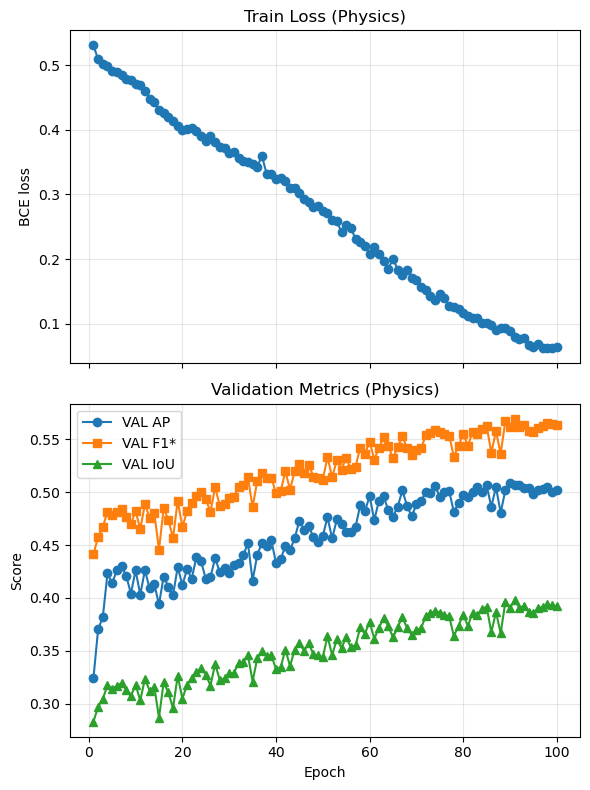

In [5]:
if not train_loss_hist:
    print("Training history empty — rerun the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (Physics)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    if val_iou_hist:
        axes[1].plot(metric_epochs, val_iou_hist, marker="^", label="VAL IoU")
    axes[1].set_title("Validation Metrics (Physics)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()

In [6]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[Physics] Computation metrics summary:
  Learnable parameters         12038401
  Avg. epoch wall time         1.948 s
  Epoch time stdev             3.159 s
  Training throughput          615.906 tiles/s
  Peak GPU memory              2.299 GB
  Inference latency (1 tile)   12.864 ms


In [7]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64


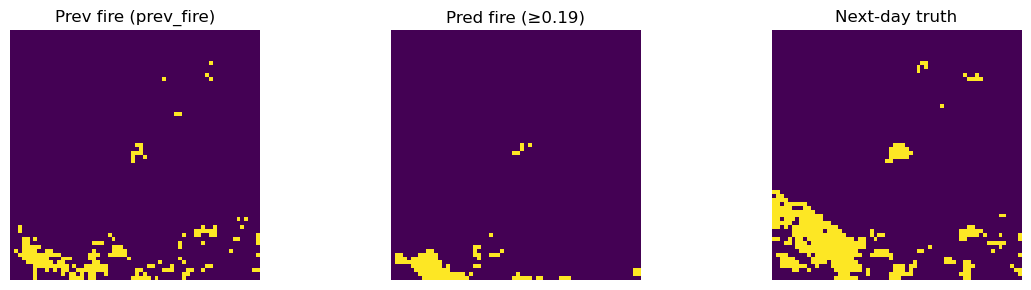

In [8]:
# =========================================================
# Quick qualitative visualization for PhysicsPrior UNet
# =========================================================
@torch.no_grad()
def show_one_physics(ds, model_obj=None, i=0, thr=None):
    if model_obj is None:
        model_obj = physics_model
    if thr is None:
        thr = best_thr_val
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0
    batch = ds[i]
    X_raw0 = batch["X_raw"].unsqueeze(0).to(device)
    y = batch["y"][0].numpy()
    feats = feature_builder(X_raw0)
    prob = torch.sigmoid(model_obj(feats))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(thr)).astype(np.float32)
    prev_img = batch["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1)
    axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1)
    axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1)
    axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout()

# Example
show_one_physics(test_ds, i=0)

In [9]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_iou_hist": list(val_iou_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /home/jbm2rt/wildfire_artifacts/physics_unet/physics_unet.pt


In [10]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}


def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone


ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val, iou_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test, iou_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_iou": iou_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_iou": iou_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} IoU {stats['val_iou']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f} IoU {stats['test_iou']:.4f}"
    )

Final metrics (val/test):
  Raw    | VAL AP 0.5087 F1 0.5619 IoU 0.3907 thr≈0.329 | TEST AP 0.4687 F1 0.5118 IoU 0.3439
  EMA    | VAL AP 0.5332 F1 0.5792 IoU 0.4077 thr≈0.292 | TEST AP 0.5074 F1 0.5358 IoU 0.3659
  Polyak | VAL AP 0.4766 F1 0.5269 IoU 0.3576 thr≈0.439 | TEST AP 0.4537 F1 0.5008 IoU 0.3340


Using EMA weights for confusion/PR with thr≈0.292
VAL @thr: {'tp': 23092, 'fp': 19339, 'tn': 1172156, 'fn': 14213, 'precision': 0.5442247413446433, 'recall': 0.6190054952417587, 'f1': 0.579211392632639, 'iou': 0.4076689499328424}
TEST @thr: {'tp': 23476, 'fp': 25429, 'tn': 1164541, 'fn': 15354, 'precision': 0.4800327164910582, 'recall': 0.6045840844706144, 'f1': 0.5351570019615786, 'iou': 0.3653340388116271}


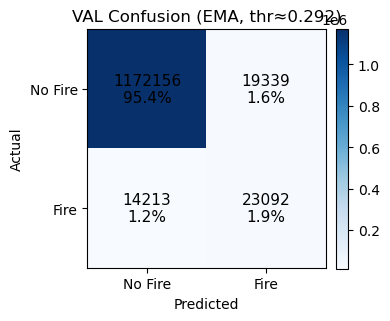

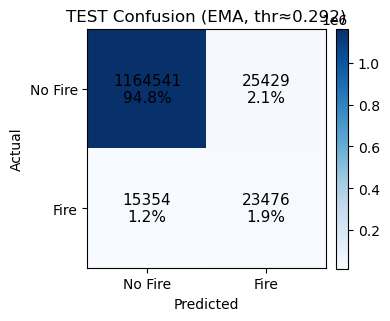

In [11]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1), iou=float(iou))


def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)


def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()


val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


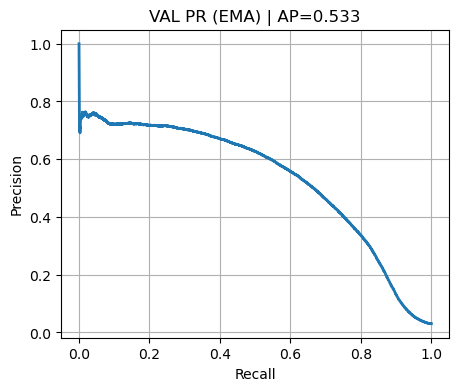

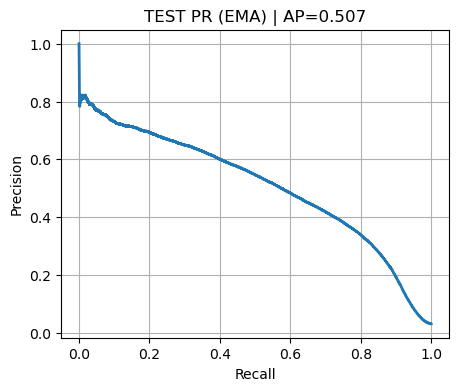

In [12]:
@torch.no_grad()
def pr_curve(model_obj, loader, title="PR Curve"):
    model_obj.eval()
    ps, ts = [], []
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        p = torch.sigmoid(model_obj(feats)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p)
        ts.append(t)
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(best_model, val_loader, f"VAL PR ({best_name})")
pr_curve(best_model, test_loader, f"TEST PR ({best_name})")

TEST metrics: {'ap': 0.5074125967942882, 'best_f1': 0.5357588020161346, 'best_thr': 0.31596052646636963, 'chosen_thr': 0.29222944378852844, 'iou': 0.3653340388116271}
Confusion counts: {'TP': 23476.0, 'FP': 25429.0, 'FN': 15354.0}
Confusion matrix:
 [[1164541   25429]
 [  15354   23476]]


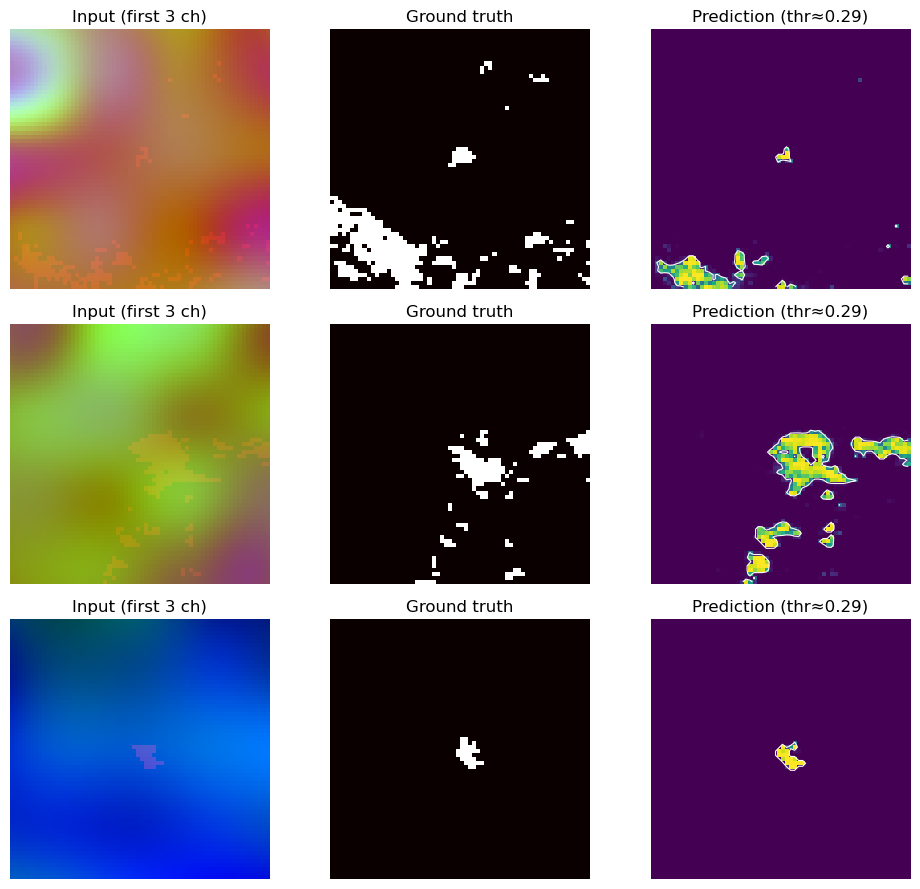

In [13]:
# =========================================================
# Test-set evaluation + qualitative checks
# =========================================================
@torch.no_grad()
def run_test(model_obj, loader, threshold=None, desc="TEST eval"):
    model_obj.eval()
    probs_all, targets_all = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        probs_all.append(torch.sigmoid(logits).detach().cpu())
        targets_all.append(y.detach().cpu())
    probs = torch.cat(probs_all, dim=0)
    targets = torch.cat(targets_all, dim=0)
    p_flat = probs.flatten().numpy()
    t_flat = targets.flatten().numpy()
    ap = average_precision_score(t_flat, p_flat)
    prec, rec, thr = precision_recall_curve(t_flat, p_flat)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr_curve = thr[best_idx] if best_idx < len(thr) else 0.5
    chosen_thr = float(threshold if threshold is not None else best_thr_curve)
    binary = (probs >= chosen_thr).float()
    tp = float((binary * targets).sum().item())
    fp = float((binary * (1 - targets)).sum().item())
    fn = float((((1 - binary) * targets)).sum().item())
    intersection = tp
    union = float(binary.sum().item() + targets.sum().item() - intersection)
    iou = intersection / (union + 1e-8)
    metrics = {
        "ap": float(ap),
        "best_f1": float(f1.max()),
        "best_thr": float(best_thr_curve),
        "chosen_thr": chosen_thr,
        "iou": float(iou),
    }
    confusion_counts = {"TP": tp, "FP": fp, "FN": fn}
    cm = confusion_matrix(t_flat.astype(int), binary.flatten().numpy().astype(int), labels=[0, 1])
    return metrics, confusion_counts, cm


test_metrics, test_confusion, test_cm = run_test(best_model, test_loader, threshold=best_thr, desc=f"TEST {best_name}")
print("TEST metrics:", test_metrics)
print("Confusion counts:", test_confusion)
print("Confusion matrix:\n", test_cm)


@torch.no_grad()
def visualize_predictions(loader, model_obj=None, n=4, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    loader_iter = iter(loader)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))
    axes = np.atleast_2d(axes)
    for row in range(n):
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            batch = next(loader_iter)
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        prob = torch.sigmoid(logits).detach().cpu()
        x_raw = batch["X_raw"][0].cpu().numpy()
        img = x_raw[:3]
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        gt = y[0, 0].cpu().numpy()
        pred = prob[0, 0].numpy()
        axs = axes[row]
        axs[0].imshow(np.moveaxis(img, 0, -1))
        axs[0].set_title("Input (first 3 ch)")
        axs[0].axis("off")
        im1 = axs[1].imshow(gt, cmap="hot")
        axs[1].set_title("Ground truth")
        axs[1].axis("off")
        im2 = axs[2].imshow(pred, cmap="viridis")
        axs[2].contour(pred, levels=[thr], colors="white", linewidths=0.8)
        axs[2].set_title(f"Prediction (thr≈{thr:.2f})")
        axs[2].axis("off")
    plt.tight_layout()


visualize_predictions(test_loader, model_obj=best_model, n=3, threshold=test_metrics.get("chosen_thr", best_thr))

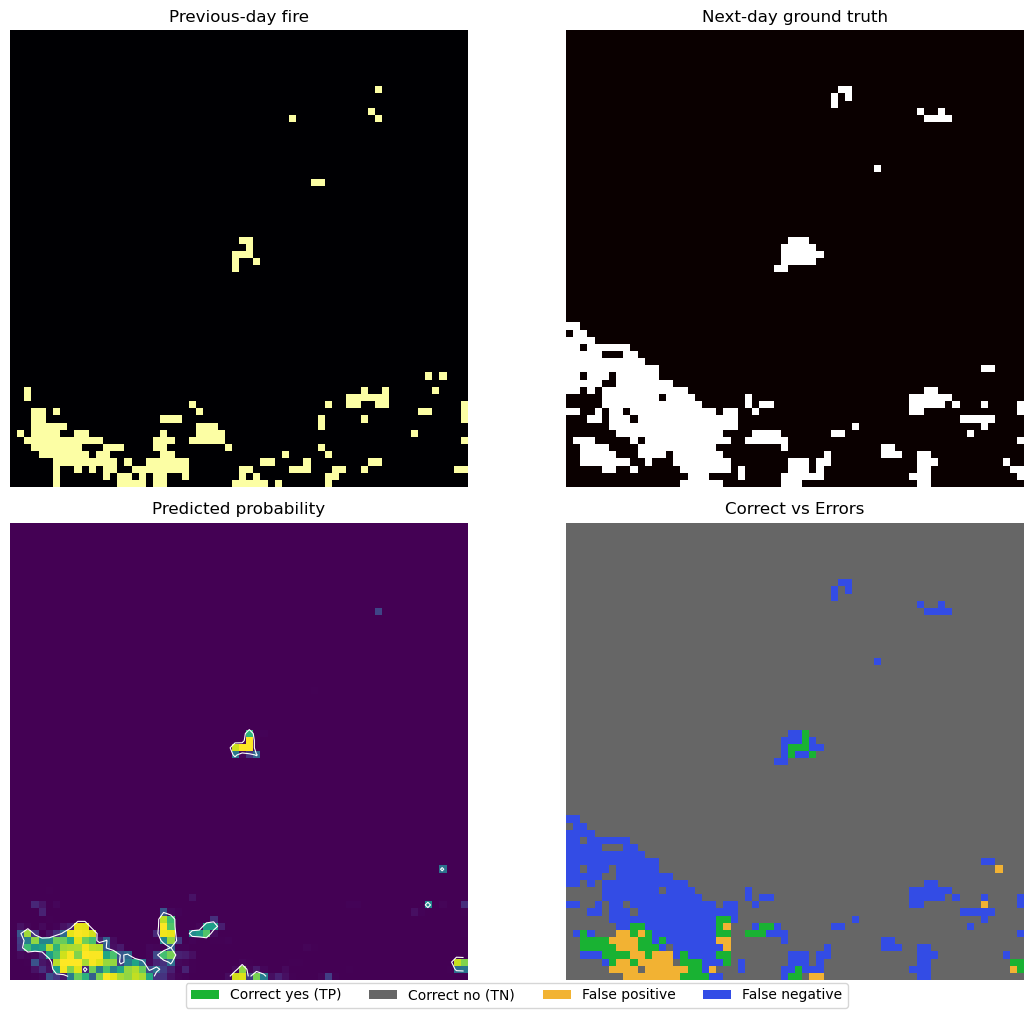

In [14]:
# =========================================================
# Single-tile error-type visualization
# =========================================================
@torch.no_grad()
def plot_error_breakdown(loader, model_obj=None, threshold=None):
    if model_obj is None:
        model_obj = best_model
    thr = float(threshold if threshold is not None else test_metrics.get("chosen_thr", best_thr))
    batch = next(iter(loader))
    feats, y = _forward_batch(model_obj, batch)
    logits = model_obj(feats)
    prob = torch.sigmoid(logits).detach().cpu().numpy()[0, 0]
    pred_mask = (prob >= thr).astype(np.float32)
    gt_mask = y[0, 0].cpu().numpy()
    channel_names = getattr(loader.dataset, "channels", CHANNELS_FOR_MODEL)
    prev_idx = channel_names.index("prev_fire") if "prev_fire" in channel_names else 0
    prev_fire = batch["X_raw"][0, prev_idx].cpu().numpy()
    prev_fire = (prev_fire - prev_fire.min()) / (prev_fire.max() - prev_fire.min() + 1e-6)

    correct_yes = np.logical_and(pred_mask == 1, gt_mask == 1)
    correct_no = np.logical_and(pred_mask == 0, gt_mask == 0)
    false_pos = np.logical_and(pred_mask == 1, gt_mask == 0)
    false_neg = np.logical_and(pred_mask == 0, gt_mask == 1)

    palette = {
        "TP": np.array([0.1, 0.7, 0.2]),
        "TN": np.array([0.4, 0.4, 0.4]),
        "FP": np.array([0.95, 0.7, 0.2]),
        "FN": np.array([0.2, 0.3, 0.9]),
    }
    error_map = np.zeros((*gt_mask.shape, 3), dtype=np.float32)
    error_map[correct_yes] = palette["TP"]
    error_map[correct_no] = palette["TN"]
    error_map[false_pos] = palette["FP"]
    error_map[false_neg] = palette["FN"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes[0, 0].imshow(prev_fire, cmap="inferno")
    axes[0, 0].set_title("Previous-day fire")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(gt_mask, cmap="hot")
    axes[0, 1].set_title("Next-day ground truth")
    axes[0, 1].axis("off")

    axes[1, 0].imshow(prob, cmap="viridis")
    axes[1, 0].contour(prob, levels=[thr], colors="white", linewidths=0.8)
    axes[1, 0].set_title("Predicted probability")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(error_map)
    axes[1, 1].set_title("Correct vs Errors")
    axes[1, 1].axis("off")

    legend_patches = [
        Patch(facecolor=palette["TP"], edgecolor="none", label="Correct yes (TP)"),
        Patch(facecolor=palette["TN"], edgecolor="none", label="Correct no (TN)"),
        Patch(facecolor=palette["FP"], edgecolor="none", label="False positive"),
        Patch(facecolor=palette["FN"], edgecolor="none", label="False negative"),
    ]
    fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()


plot_error_breakdown(test_loader, model_obj=best_model, threshold=test_metrics.get("chosen_thr", best_thr))